<a href="https://colab.research.google.com/github/Birkbeck/bsc-computer-science-project-2021_22-mohammadreza490/blob/main/project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up paths and import libraries

In [1]:
#Set the following variables
PATH_TO_SRC_FOLDER = r"c:\Users\Rohan\Desktop\DSP\Final-Year-Project\src"
PATH_TO_PROJECT_FOLDER = r"c:\Users\Rohan\Desktop\DSP\Final-Year-Project"

In [2]:
#if you stored the unzipped file in google drive, you can mount your drive in colab at /content/gdrive like below
'''
from google.colab import drive
drive.mount("/content/gdrive")
'''

'\nfrom google.colab import drive\ndrive.mount("/content/gdrive")\n'

In [3]:
'''
!pip install musdb
!pip install numpy
!pip install pydub
!pip install tensorflow==2.14
!pip install tensorflow-addons==0.22.0
!pip install ipdb
!pip install museval
!pip install librosa
!pip install matplotlib
'''

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import IPython.display as ipd
import musdb
import subprocess
import pydub
import tensorflow_addons as tfa
import time
import shutil
import ipdb
import scipy as sp
import soundfile as sf
import museval
import random
import math

from scipy.io.wavfile import write
from glob import glob

C:\Users\Rohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import sys
if PATH_TO_SRC_FOLDER not in sys.path:
  sys.path.append(PATH_TO_SRC_FOLDER) #https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab

In [7]:
from config_handler import Config_Handler
from dataset_handler import Dataset_Handler
from model_architecture_builder import Model_Architecture_Builder
from model_handler import Model_Handler
from printer import Printer
from visualiser import Visualiser
from wav_file_handler import Wav_File_Handler

In [8]:
Config_Handler.init(PATH_TO_PROJECT_FOLDER)

c:\Users\Rohan\Desktop\DSP\Final-Year-Project\Models already exists


## Training a model (same as model_shfl_vocal_mdl6)


In [8]:
def loss_function(y_true:np.array, y_pred:np.array, alpha:float=1.0)->float:
      '''
      this returns the customised loss function as mentioned in the paper
      the result will be calculated as loss(Singing Voice) = alpha ∗ L(vocal, channelvocal) +(1 − alpha) ∗ L(acc, channelacc)
      where L() is the average of L1 losses on every pixel. with alpha = 1.0, we only get the vocals and not the accompaniments
      '''
      vocal_loss = tf.reduce_mean(tf.abs(y_true[..., 0] - y_pred[..., 0]))
      accompaniment_loss = tf.reduce_mean(tf.abs(y_true[..., 1] - y_pred[..., 1]))
      #L1 loss function: https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions
      return alpha * vocal_loss + (1 - alpha) * accompaniment_loss

def learning_rate_scheduler(epoch:int, lr:float)->float:
     if epoch == 20:
       lr = 1e-4 
     return lr

def data_generator(model:Model_Handler, batch_size:int=8):
        path_to_dir = Config_Handler.PATH_TO_TRAIN_DATA_DIR()
        available_musics =  os.listdir(path_to_dir)
        if f"{model._model_name}-spectrograms" in available_musics:
            available_musics.remove(f"{model._model_name}-spectrograms")
        if "model_9_vocal_with_model_6_data_generator-spectrograms" in available_musics:
            available_musics.remove("model_9_vocal_with_model_6_data_generator-spectrograms")
        music_dict = {}
        for music_name in available_musics:
            
            path = os.path.join(Config_Handler.PATH_TO_TEMP_SPECTROGRAMS_FOR_TRAINING_DIR(), music_name)
            number_of_available_segments = Wav_File_Handler(audio_path = os.path.join(Config_Handler.PATH_TO_TRAIN_DATA_DIR(), music_name, "mixture.wav")).get_number_of_possible_segments()
            music_dict[music_name] = {"available_spectrograms_ids": [str(spec_id) for spec_id in range(number_of_available_segments)]}
        batch_X = []
        batch_y = {"vocal_spectrograms" : [],
        "ac_spectrograms": []}
        
        while len(available_musics) > 0:
            np.random.shuffle(available_musics)
            for music_name in reversed(available_musics):
                spec_dir_path = os.path.join(Config_Handler.PATH_TO_TEMP_SPECTROGRAMS_FOR_TRAINING_DIR(), music_name)
                specs = np.load(os.path.join(spec_dir_path, "spectrograms.npy"), allow_pickle=True).item()
                while len(music_dict[music_name]["available_spectrograms_ids"]) > 0:
                    np.random.shuffle(music_dict[music_name]["available_spectrograms_ids"])
                    if len(music_dict[music_name]["available_spectrograms_ids"]) < batch_size:
                        spectrogram_ids_to_select = music_dict[music_name]["available_spectrograms_ids"]
                    else:
                        spectrogram_ids_to_select = music_dict[music_name]["available_spectrograms_ids"][:batch_size]
                    segments_ids_to_select = [spec_id for spec_id in spectrogram_ids_to_select]
                    music_dict[music_name]["available_spectrograms_ids"] = music_dict[music_name]["available_spectrograms_ids"][batch_size:]
                    batch_X = np.array([specs[spec_id]["mixture"] for spec_id in segments_ids_to_select])
                    batch_y["vocal_spectrograms"] = np.array([specs[spec_id]["vocals"] for spec_id in segments_ids_to_select])
                    batch_y["ac_spectrograms"] = np.array([specs[spec_id]["accompaniment"] for spec_id in segments_ids_to_select])
                    X = np.array(batch_X)
                    y = np.array(np.stack([batch_y["vocal_spectrograms"], batch_y["ac_spectrograms"]], axis=-1))
                    X = tf.squeeze(X)
                    y = tf.squeeze(y)
                    X = tf.expand_dims(X, -1) #this is for the input channel numbers (the input layer of cnn is has only one channel (look at the structure in the paper))
                    y = tf.expand_dims(y, -1)
                    if len(X.shape) == 3:
                        #if for example there is only one element (one spectrogram), we add a batch size of one at the beggining
                        X = tf.expand_dims(X, 0) #this is for the input channel numbers (the input layer of cnn is has only one channel (look at the structure in the paper))
                        y = tf.expand_dims(y, 0)
                    batch_X = []
                    batch_y = {"vocal_spectrograms" : [],
                "ac_spectrograms": []}
                    yield(X, y)
                    if len(music_dict[music_name]["available_spectrograms_ids"]) == 0:
                        available_musics.remove(music_name)
                    if len(available_musics) == 0:
                        break 

In [ ]:
new_model = Model_Handler("new_model")

In [ ]:
new_model.train(loss_function, data_generator, learning_rate_scheduler)

## Load the pretrained model

In [9]:
model_shfl_vocal_mdl6 = Model_Handler("model_shfl_vocal_mdl6") #loading the pretrained vocal model

c:\Users\Rohan\Desktop\DSP\Final-Year-Project\Models\model_shfl_vocal_mdl6 already exists
c:\Users\Rohan\Desktop\DSP\Final-Year-Project\Models\model_shfl_vocal_mdl6\model_shfl_vocal_mdl6-trained-model already exists
c:\Users\Rohan\Desktop\DSP\Final-Year-Project\Models\model_shfl_vocal_mdl6\checkpoint already exists
c:\Users\Rohan\Desktop\DSP\Final-Year-Project\Models\model_shfl_vocal_mdl6\tensorboard_logs already exists
Loading the pre-trained model!


In [10]:
#to predict a song, either load it using librosa.load function or pass the full song path to the predict method

# READ WAV
y, sr = librosa.load(r"c:\Users\Rohan\Music\Neon Genesis Evangelion — Fly Me to the Moon.wav", sr=None)

v, a, o = model_shfl_vocal_mdl6.predict(y) #set either wav_array or audio_path here

None


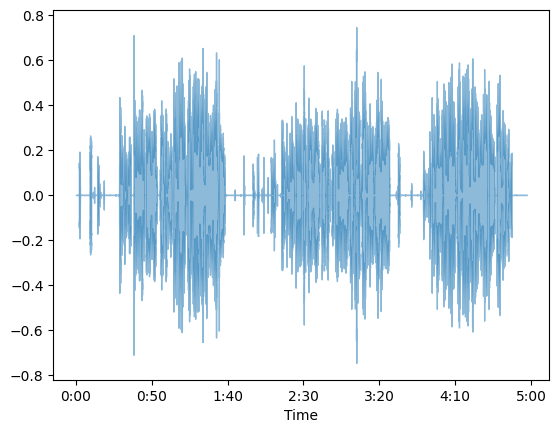

In [11]:
print(Visualiser.visualise_wav(v))

orig_rate = 48000

v_wav = v.wav_file
v_rate = v.sample_rate
write('FMTTM_vocal.wav', orig_rate, v_wav)

a_wav = a.wav_file
a_rate = a.sample_rate
write('FMTTM_accomp.wav', orig_rate, a_wav)

## THE FOLLOWING STUFF BELOW ARE 'SCRIBBLES'

In [10]:
!musdbconvert "C:\Users\Rohan\Desktop\DSP\Final-Year-Project\Dataset\musdb18" "C:\Users\Rohan\Desktop\DSP\Final-Year-Project\Dataset\musdb18wav"

^C



100%|██████████| 150/150 [23:35<00:00,  9.44s/it]


In [11]:
PATH_TO_MUSDB_TRAIN = r"C:\Users\Rohan\Desktop\DSP\Final-Year-Project\Dataset\musdb18\train\*.mp4"
PATH_TO_MUSDB_TEST = r"C:\Users\Rohan\Desktop\DSP\Final-Year-Project\Dataset\musdb18\test\*.mp4"

train_stems = glob(PATH_TO_MUSDB_TRAIN)
test_stems = glob(PATH_TO_MUSDB_TEST)

In [12]:
# SPLIT SONG INTO 2-SECOND SEGMENTS
# TRANSFORM IT SO THAT THERE IS NO REMAINDER (ALL SEGMENTS ARE 2 SECONDS)

def zeroPad(wav, sr):
    padLength = sr*2 - len(wav) % (sr*2)
    pad = np.zeros(padLength)
    padded = np.append(wav, pad)

    return padded

def segmentWav(wav, sr):
    twoSec = sr * 2

    return np.split(wav, len(wav) / int(twoSec))


In [22]:
y, sr = librosa.load(r"c:\Users\Rohan\Music\Neon Genesis Evangelion — Fly Me to the Moon.wav", sr=None)
padded = zeroPad(y, sr)
split = segmentWav(padded, sr)

SEGMENT_INDEX = 200

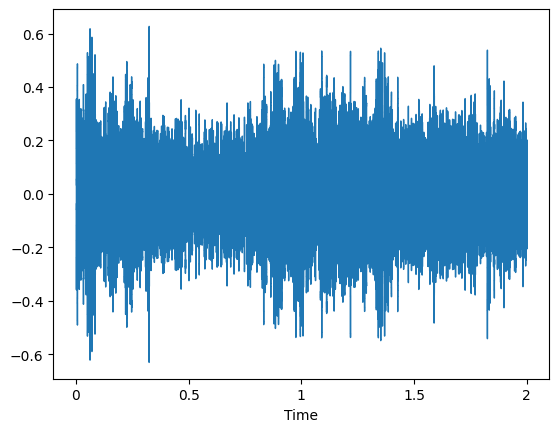

In [31]:
# NOTE: librosa is built on top of matplotlib

# TIME DOMAIN
def plotWav(y, sr):
    librosa.display.waveshow(y, sr=sr)
    # plt.xlabel("Time")
    # plt.ylabel("Amplitude")
    plt.show()

plotWav(split[SEGMENT_INDEX], sr)

write('orig.wav', sr, split[SEGMENT_INDEX])

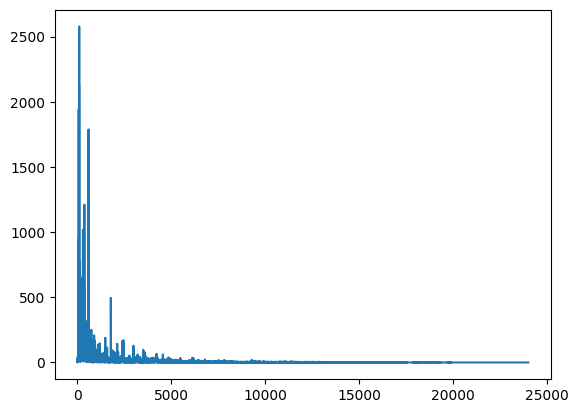

In [15]:
# FREQUENCY DOMAIN (FFT) -> 'Snapshot' of the whole range and the average magnitudes throughout the signal

# COMPUTE FFT
def computeFFT(y, sr):
    fft = np.fft.fft(y)
    magnitude = np.abs(fft) # 'Power' of each frequency
    freq = np.linspace(0, sr, len(magnitude)) # Sample rate determines the frequencies that can be captured

    left_magnitude = magnitude[:int(len(freq)/2)] 
    left_freq = freq[:int(len(freq)/2)] # halved because we only need half of the sample rate to recreate the signal (Nyquist Theorem WOWOWOWOW)

    return left_magnitude, left_freq

def plotFFT(freq, magnitude):
    plt.plot(freq, magnitude)
    # plt.xlabel("Frequency")
    # plt.ylabel("Power")
    # plt.show()

left_magnitude, left_freq = computeFFT(split[SEGMENT_INDEX], sr)
plotFFT(left_freq, left_magnitude)

(1025, 188)
[  3.60683827  13.08193409  14.0421253    8.55117089   2.15045764
   6.23056601   9.61595673  13.24972451  11.9001434    6.88336743
   8.7126535    9.1795952    9.87338698  10.6886854    9.44196995
   7.89745707   0.44908781  -2.07363591   9.80715643  11.42187986
   8.18337898   2.61827317  -1.35886513  -0.08973346  -4.58694707
  10.84390853  13.74073215   8.86005387  12.18733586  18.02317594
  11.82261865   2.31194714  15.98994129  16.29290395   5.67603276
  13.65739645  17.88353819  12.07703951  -5.60825502   1.37716875
   4.66195059  10.19420184   9.06606196   5.8381698    7.91737032
  11.96485745  13.53939983  12.15178705  11.11716273   8.38317965
   9.71938602  13.0422325   12.7485922    9.27106023   0.57134807
  11.06945709   7.58148697 -11.13643304   6.50030346   8.82378868
   7.104755     1.4448741   -2.77620541   7.71515538  12.31463591
  14.07449149  15.12773329  10.705255    11.7492864   14.48135347
  13.24697161  12.55676017   6.86477576  11.03965901  15.8942149

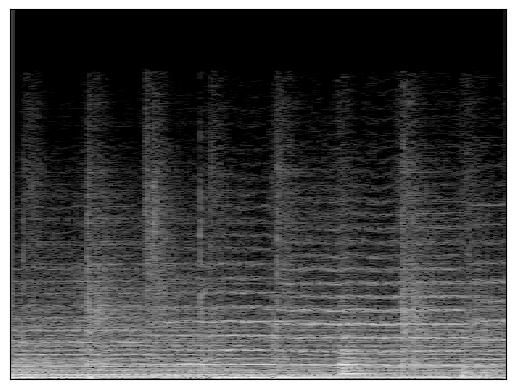

In [49]:
# TIME-FREQUENCY DOMAIN (STFT) -> Computes the transforms of several windows throughout the signal, with the color representing the magnitude (similar to a heat map)

# COMPUTE STFT
def computeSTFT(wav, window, hop):
    stft = librosa.core.stft(wav, n_fft=window, hop_length=hop)
    spectogram = np.abs(stft) # Linear
    log_spectogram = librosa.amplitude_to_db(spectogram) # We make sense of sound logarithmically

    return log_spectogram

def plotSpec(stft, sr, hop, name):
    fig = librosa.display.specshow(stft, sr=sr, hop_length=hop)
    plt.gray()
    # plt.xlabel("Time")
    # plt.ylabel("Frequency")
    plt.savefig(name, bbox_inches='tight', pad_inches=0)

n_fft = 2048
hop_length = 512
stft = computeSTFT(split[SEGMENT_INDEX], n_fft, hop_length)

plotSpec(stft, sr, hop_length, "sample.png")

print(stft.shape)
print(stft[50])

In [36]:
# FROM SPECTOGRAM, COMPUTE ISTFT

'''
complex_segment_phases = librosa.magphase(stft)[1]
stft = stft[:, :complex_segment_phases.shape[1]] # removes the added silence during original segmentation of data
complex_stft = np.multiply(complex_segment_phases, stft)
'''

# step2 - converting audio np array to spectrogram
spec = librosa.feature.melspectrogram(y=split[SEGMENT_INDEX],
                                        sr=sr, 
                                            n_fft=2048, 
                                            hop_length=512, 
                                            win_length=None, 
                                            window='hann', 
                                            center=True, 
                                            pad_mode='reflect', 
                                            power=2.0,
                                     n_mels=128)

spec_2 = librosa.feature.melspectrogram(y=split[SEGMENT_INDEX + 1],
                                        sr=sr, 
                                            n_fft=2048, 
                                            hop_length=512, 
                                            win_length=None, 
                                            window='hann', 
                                            center=True, 
                                            pad_mode='reflect', 
                                            power=2.0,
                                     n_mels=128)

# step3 converting mel-spectrogram back to wav file
res = librosa.feature.inverse.mel_to_audio(spec, 
                                           sr=sr, 
                                           n_fft=2048, 
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2.0, 
                                           n_iter=32)

res_2 = librosa.feature.inverse.mel_to_audio(spec_2, 
                                           sr=sr, 
                                           n_fft=2048, 
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2.0, 
                                           n_iter=32)

write('istft.wav', sr, np.concatenate((res, res_2), axis=None))

A Classic Education - NightOwl
ANiMAL - Clinic A
ANiMAL - Easy Tiger
ANiMAL - Rockshow
Actions - Devil_s Words
Actions - One Minute Smile
Actions - South Of The Water
Aimee Norwich - Child
Alexander Ross - Goodbye Bolero
Alexander Ross - Velvet Curtain
Angela Thomas Wade - Milk Cow Blues
Atlantis Bound - It Was My Fault For Waiting
Auctioneer - Our Future Faces
AvaLuna - Waterduct
BigTroubles - Phantom
Bill Chudziak - Children Of No-one
Black Bloc - If You Want Success
Celestial Shore - Die For Us
Chris Durban - Celebrate
Clara Berry And Wooldog - Air Traffic
Clara Berry And Wooldog - Stella
Clara Berry And Wooldog - Waltz For My Victims
Cnoc An Tursa - Bannockburn
Creepoid - OldTree
Dark Ride - Burning Bridges
Dreamers Of The Ghetto - Heavy Love
Drumtracks - Ghost Bitch
Faces On Film - Waiting For Ga
Fergessen - Back From The Start
Fergessen - Nos Palpitants
Fergessen - The Wind
Flags - 54
Giselle - Moss
Grants - PunchDrunk
Helado Negro - Mitad Del Mundo
Hezekiah Jones - Borrowed Hear

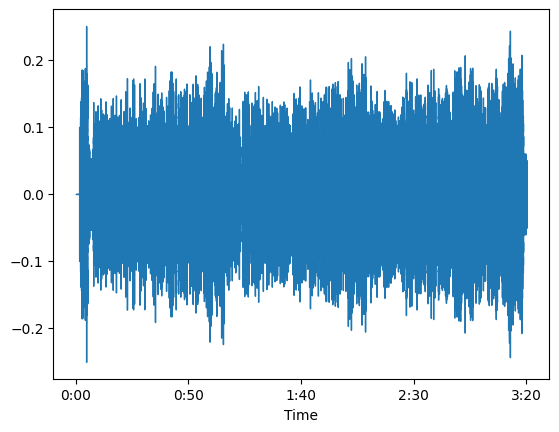

In [48]:
# CREATE FUNCTION THAT REPRODUCES THE SONG BUT WITHOUT THE BASS STEM

mus = musdb.DB(root=r"C:\Users\Rohan\Desktop\DSP\Final-Year-Project\Dataset\musdb18")

#mus_train = musdb.DB(subsets="train")
#mus_test = musdb.DB(subsets="test")          

for track in mus:
    print(track.name)
               

drums, sr = librosa.load(r"Dataset/musdb18wav/test/Al James - Schoolboy Facination/drums.wav", sr=None)
vocals, sr = librosa.load(r"Dataset/musdb18wav/test/Al James - Schoolboy Facination/vocals.wav", sr=None)
other, sr = librosa.load(r"Dataset/musdb18wav/test/Al James - Schoolboy Facination/other.wav", sr=None)

librosa.display.waveshow((drums + vocals + other)/3, sr=sr)

write('bassless.wav', sr, (drums + vocals + other)/3)

In [17]:
# CREATE U-NET MODEL

# Spectogram dimensions
IMG_WIDTH = 1025
IMG_HEIGHT = 188
IMG_CHANNELS = 1


# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalize image values

# Contraction path -> Extract details
'''
relu ensures that values are nonnegative
kernel_initializer initializes weights(?) based on some probability distribution / function?
padding denotes that the dimensions should be the same

skip connections allow the model to "remember" what it's trying to recreate instead of just working with its details (i.e. features) https://ai.stackexchange.com/questions/37321/what-is-the-role-of-skip-connections-in-u-net
the dropout drops out nodes in the input and hidden layer with probability p to ensure that the model is not overfitting


C1:
16 filters that are 3 by 3, filters define the features
Drop 10%(?)
Another 16 filters that are 3 by 3
Max pooling layer 2 by 2 with stride 2 compresses the image to half its size

C2: 
32 filters that are 3 by 3
Drop 10%(?)
Another 32 filters
Max pooling layer halves the size again

C3:
...

C4:
...

C5:
...

'''
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path -> Upsample, recreate image
'''
C6:
Upsample C5 (i.e. Double the dimensions and halve the features) via transpose, call this U6
Apply skip connections via concatenate (Append features from C4 to U6)
Layer with half the features as C6 (Why?)

C7:
Upsample C6 (i.e. Double the dimensions and halve the features) via transpose, call this U7
Apply skip connections via concatenate (Append features from C3 to U7)
Layer with half the features as C6

C8:
...

C9:
...

Dense Layer:
Flatten the 128*128*16 and map (fully) to 128*128*1 pixels (original image) 

'''
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 368, 496, 16), (None, 369, 496, 16)]

In [19]:
'''

1. Convert stems to wav. https://pypi.org/project/musdb/ 
2. For each song, split into 2 second segments. Add padding as needed
1. For each segment, create spectogram of whole mix of each song in training set via STFT
2. Create array containing spectograms of bass of each song in training set
3. Create array containing spectograms of (whole mix - bass) of each song in training set, see https://stackoverflow.com/questions/4039158/mixing-two-audio-files-together-with-python
4. Add padding to arrays such that shape is appropriate for the network.
4. Create CNN model
5. Train model
6. Apply inverse STFT / Get signal from the spectogram, see https://stackoverflow.com/questions/60377585/how-can-i-reverse-a-scipy-signal-spectrogram-to-audio-with-python
                                                        https://stackoverflow.com/questions/76447360/how-do-i-can-reconstructing-stft-to-audio
                                                        https://stackoverflow.com/questions/69387104/how-to-convert-wav-audio-file-from-mel-spectrogram
7. Test model with a bunch of songs

https://medium.com/@shameerayaseen21/u-net-advancing-image-segmentation-with-convolutional-neural-networks-1fd810f05d00
'''

'\n\n1. Convert stems to wav. https://pypi.org/project/musdb/ \n2. For each song, split into 2 second segments.\n1. For each segment, create spectogram of whole mix of each song in training set\n2. Create array containing spectograms of bass of each song in training set\n3. Create array containing spectograms of (whole mix - bass) of each song in training set\n4. Create CNN model\n5. Train model\n6. Apply inverse STFT / Get signal from the spectogram, see https://stackoverflow.com/questions/60377585/how-can-i-reverse-a-scipy-signal-spectrogram-to-audio-with-python\n                                                        https://stackoverflow.com/questions/76447360/how-do-i-can-reconstructing-stft-to-audio\n7. Test model with a bunch of songs\n\nhttps://medium.com/@shameerayaseen21/u-net-advancing-image-segmentation-with-convolutional-neural-networks-1fd810f05d00\n'

In [ ]:
from tensorflow.keras import datasets, layers, models

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# The four models trained in this project were coded like this:

In [ ]:
model_shfl_vocal_mdl6 = Model_Handler("model_shfl_vocal_mdl6") #only vocals
model_shfl_accompaniment_mdl6 = Model_Handler("model_shfl_accompaniment_mdl6") #only accompaniments
model_shfl_half_alpha_mdl6 = Model_Handler("model_shfl_half_alpha_mdl6") #half vocals and half accompaniments
model_shfl_more_vocals_mdl6 = Model_Handler("model_shfl_more_vocals_mdl6") #more vocals

In [ ]:
model_shfl_vocal_mdl6.train(loss_function, data_generator, learning_rate_scheduler)

In [ ]:
model_shfl_accompaniment_mdl6.train(lambda y_true, y_pred: loss_function(y_true, y_pred, 0.0), data_generator, learning_rate_scheduler)

In [ ]:
model_shfl_half_alpha_mdl6.train(lambda y_true, y_pred: loss_function(y_true, y_pred, 0.50), data_generator, learning_rate_scheduler)

In [ ]:
model_shfl_more_vocals_mdl6.train(lambda y_true, y_pred: loss_function(y_true, y_pred, 0.707), data_generator, learning_rate_scheduler)